El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_188576/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'dxDAO - xDXdao'
ORG_PLATFORM: str = None
USE_ORG_NAMES: bool = True

In [3]:
# Parameters
ORG_NAME = "HUWA-DAO"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 12s:00"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 4151 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 0 to 4150
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       4151 non-null   object        
 1   name           4151 non-null   object        
 2   id             4151 non-null   object        
 3   proposal       4151 non-null   category      
 4   deployment     4151 non-null   object        
 5   platform_vote  4151 non-null   object        
 6   voter          4151 non-null   category      
 7   date           4151 non-null   datetime64[ns]
 8   choice         4151 non-null   object        
 9   weight         4151 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 322.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 580
Data columns (total 13 columns):
 #   Column               Non-Null Coun

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x4254c53fc3b3b38df025ea30bcae410e11bb95b6,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-07 09:41:01,1
1,0xa2c99645039842faac58f29c54a0e0d528dd9273,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-07 05:05:39,1
2,0xf7a3a1ddcd7c6bf710048f261eb47807d5c168a1,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-06 09:03:33,1
3,0x7bb4860dcaeec291b56a7e3f74f299628e3bb239,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-05 08:55:35,1
4,0xc24fe6f2bae027aeee47390be73d121f18f51bdb,88563e4d-a181-5acd-ab7c-6a7461316dc6,2022-06-05 01:46:00,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                           574
mean      8 days 12:39:26.311846689
std      12 days 04:23:45.232435536
min                 0 days 06:00:00
25%                 2 days 00:00:00
50%                 3 days 00:00:00
75%                 9 days 00:00:00
max               105 days 02:00:00
dtype: object

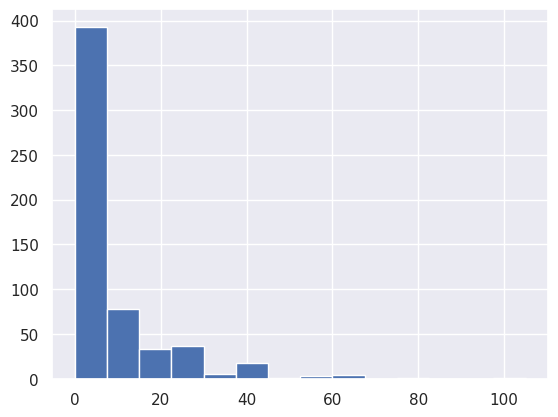

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

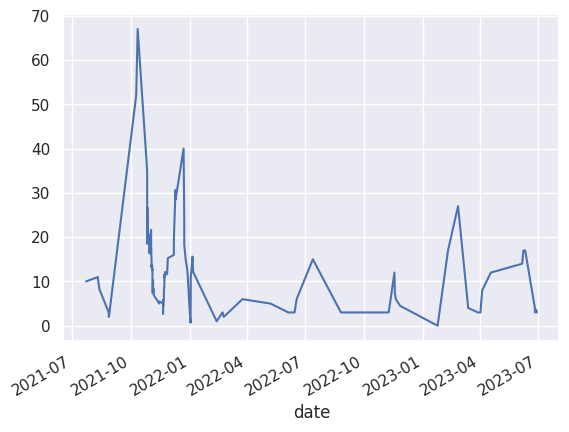

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Friday       160
Thursday     118
Wednesday     89
Monday        71
Saturday      64
Tuesday       42
Sunday        30
Name: start, dtype: int64

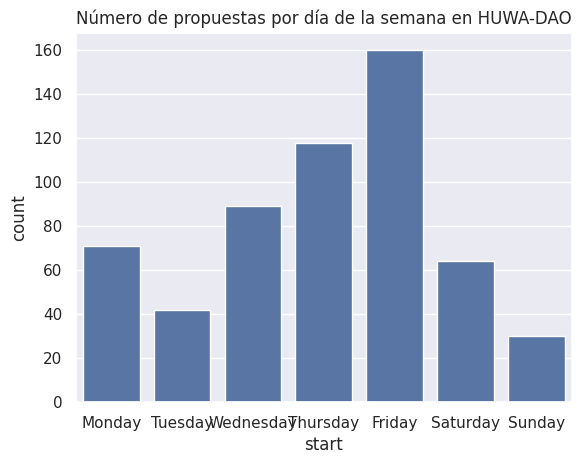

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Thursday     702
Friday       641
Tuesday      639
Wednesday    620
Saturday     578
Monday       576
Sunday       395
Name: date, dtype: int64

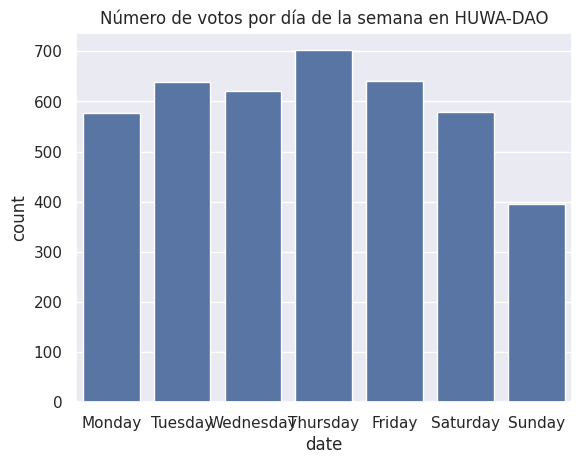

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

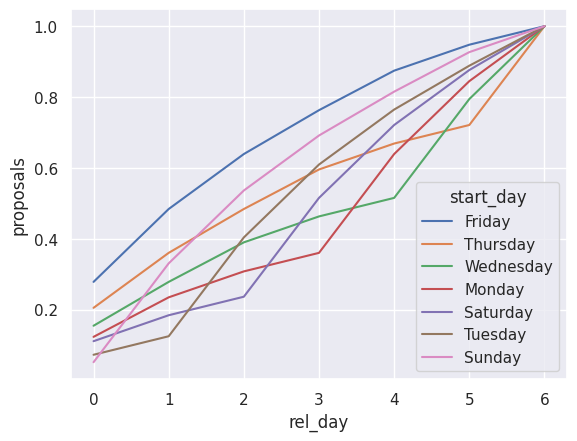

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

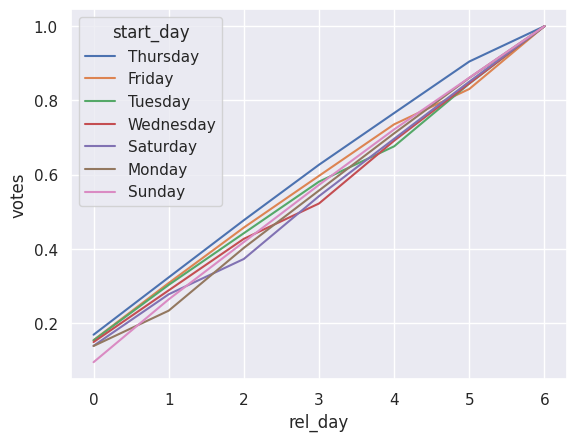

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

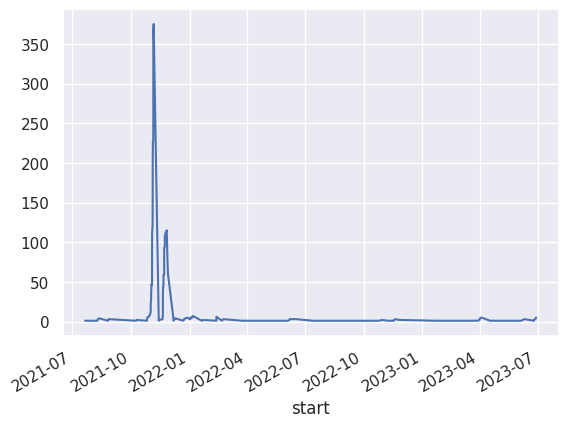

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  100.000000  100.000000  100.000000   
                                mean    52.050000   53.030000   54.590000   
                                std    143.156718  145.449110  149.467208   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    977.000000  984.000000  983.000000   
users in open proposals (train) count  100.000000  100.000000  100.000000   
                                mean    31.390000   32.460000   33.500000   
                                std     76.618153   79.679968   82.357253   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    469.000000  471.000000  474.000000   
open proposals                  count  100.000000  100.000000  100.000000   
                                mean     6.900000    6.530000    6.890000   
                                std     24.574562   22.416379   23.196959   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    167.000000  126.000000  133.000000   
votes in test                   count  100.000000  100.000000  100.000000   
                                mean     6.930000    6.040000    5.320000   
                                std     22.551962   14.553919   11.286785   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    193.000000   74.000000   65.000000   
users in test                   count  100.000000  100.000000  100.000000   
                                mean     5.060000    4.280000    3.620000   
                                std     17.586048    9.537888    7.106378   
                                min      0.000000    0.000000    0.000000   
                                50%      0.000000    0.000000    0.000000   
                                max    161.000000   52.000000   45.000000   
vpp test                        count   45.000000   45.000000   47.000000   
                                mean     3.329136    3.251410    3.028737   
                                std      4.361108    3.824470    3.487692   
                                min      0.000000    0.000000    0.000000   
                                50%      1.757576    2.000000    1.500000   
                                max     17.000000   15.000000   15.000000   
vpu test                        count   35.000000   36.000000   38.000000   
                                mean     1.309713    1.296328    1.483467   
                                std      0.420872    0.450717    1.180632   
                                min      1.000000    1.000000    1.000000   
                                50%      1.000000    1.000000    1.066667   
                                max      2.461538    3.000000    8.000000   

f                                           W-WED       W-THU        W-SAT  
votes in open proposals (train) count  100.000000  100.000000   101.000000  
                                mean    51.080000   54.480000    54.623762  
                                std    130.806950  139.137929   159.102913  
                                min      0.000000    0.000000     0.000000  
                                50%      1.000000    1.000000     0.000000  
                                max    861.000000  925.000000  1046.000000  
users in open proposals (train) count  100.000000  100.000000   101.000000  
                                mean    32.140000   33.250000    33.4554

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_188576/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),5205.000000,5303.000000,5459.000000,5108.000000,5448.000000,5517.000000
users in open proposals (train),3139.000000,3246.000000,3350.000000,3214.000000,3325.000000,3379.000000
open proposals,690.000000,653.000000,689.000000,621.000000,679.000000,787.000000
votes in test,693.000000,604.000000,532.000000,585.000000,582.000000,650.000000
users in test,506.000000,428.000000,362.000000,392.000000,349.000000,470.000000
vpp test,149.811117,146.313438,142.350649,167.878012,137.196503,116.824625
vpu test,45.839949,46.667808,56.371755,61.703568,55.896482,42.217934


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from recommenders.datasets.pandas_df_utils import filter_by

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""
def getBaselineRecommendations(train: pd.DataFrame, users, proposals, k: int = 5, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    # bestVotes = bestVotes[bestVotes.index.isin(proposals)]

    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    # Avoid recommending already voted proposals (they wont be in the test set)
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-08-27 09:01:56)  =====
Currently open proposals: 3
Train votes in open proposals:   1
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-11-28 05:17:39)  =====
Currently open proposals: 126
Train votes in open proposals: 980
Test votes in open proposals:  113



===== Training on fold 2 (t: 2022-01-28 23:17:46)  =====
Currently open proposals: 5
Train votes in open proposals: 168
Test votes in open proposals:    0

===== Training on fold 3 (t: 2022-03-30 08:53:21)  =====
Currently open proposals: 1
Train votes in open proposals:  36
Test votes in open proposals:    0

===== Training on fold 4 (t: 2022-06-08 06:37:55)  =====
Currently open proposals: 2
Train votes in open proposals:  26
Test votes in open proposals:    2



===== Training on fold 5 (t: 2022-07-27 13:26:36)  =====
Currently open proposals: 1
Train votes in open proposals:  18
Test votes in open proposals:    0

===== Training on fold 6 (t: 2022-08-28 05:32:00)  =====
Currently open proposals: 1
Train votes in open proposals:  10
Test votes in open proposals:    0

===== Training on fold 7 (t: 2022-12-01 14:09:58)  =====
Currently open proposals: 1
Train votes in open proposals:   5
Test votes in open proposals:    0

===== Training on fold 8 (t: 2023-02-21 22:34:51)  =====
Currently open proposals: 1
Train votes in open proposals:  21
Test votes in open proposals:    6



===== Training on fold 9 (t: 2023-04-26 04:50:33)  =====
Currently open proposals: 2
Train votes in open proposals:  67
Test votes in open proposals:    1



In [19]:
from src import paths

pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.061194,0.302900,0.302488,0.302985,0.030597,0.302900,0.302488,0.302985,0.020597,0.303247,0.302560,0.303856,0.092836,0.046866
std,0.095856,0.481128,0.481391,0.481074,0.047928,0.481128,0.481391,0.481074,0.031844,0.480910,0.481344,0.480533,0.125448,0.063667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.152985,0.757251,0.756219,0.757463,0.076493,0.757251,0.756219,0.757463,0.051493,0.758118,0.756400,0.759639,0.200000,0.100000
max,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000,0.328358,0.168657


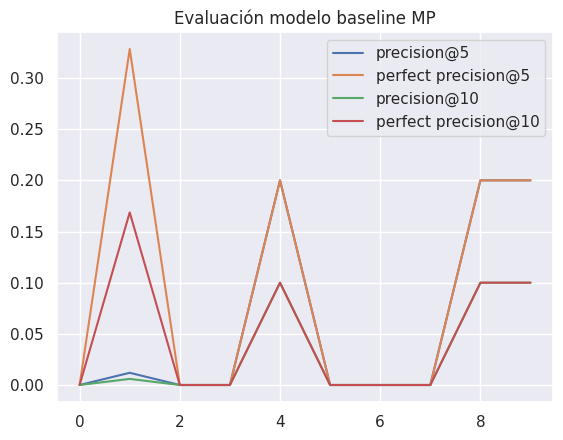

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.092836,0.400000,0.399325,0.399325,0.046866,0.400000,0.400000,0.400000,0.031244,0.400000,0.400000,0.400000
std,0.125448,0.516398,0.515530,0.515530,0.063667,0.516398,0.516398,0.516398,0.042445,0.516398,0.516398,0.516398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,1.000000,0.998312,0.998312,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
max,0.328358,1.000000,1.000000,1.000000,0.168657,1.000000,1.000000,1.000000,0.112438,1.000000,1.000000,1.000000


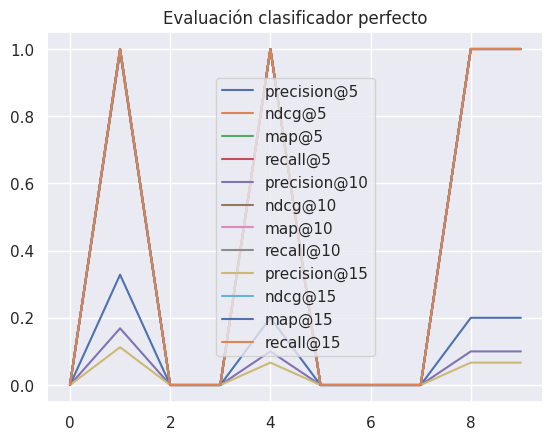

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/100 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 3
Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 6
Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 9
Warning, empty test fold 10
Warning, empty test fold 11


Warning, empty test fold 27
Warning, empty test fold 28
Warning, empty test fold 29
Warning, empty test fold 30
Warning, empty test fold 31


Warning, empty test fold 32
Warning, empty test fold 33
Warning, empty test fold 34
Warning, empty test fold 35
Warning, empty test fold 36


Warning, empty test fold 37
Warning, empty test fold 38
Warning, empty test fold 39
Warning, empty test fold 40


Warning, empty test fold 42
Warning, empty test fold 43
Warning, empty test fold 44


Warning, empty test fold 48
Warning, empty test fold 49


Warning, empty test fold 52
Warning, empty test fold 53
Warning, empty test fold 54
Warning, empty test fold 55
Warning, empty test fold 56


Warning, empty test fold 57
Warning, empty test fold 58
Warning, empty test fold 59
Warning, empty test fold 60
Warning, empty test fold 61


Warning, empty test fold 62
Warning, empty test fold 63
Warning, empty test fold 64


Warning, empty test fold 66
Warning, empty test fold 68


Warning, empty test fold 71
Warning, empty test fold 72
Warning, empty test fold 73


Warning, empty test fold 74
Warning, empty test fold 75
Warning, empty test fold 76
Warning, empty test fold 77
Warning, empty test fold 78


Warning, empty test fold 79
Warning, empty test fold 80


Warning, empty test fold 92
Warning, empty test fold 93
Warning, empty test fold 94


Warning, empty test fold 95
Warning, empty test fold 96


In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2021-07-22 11:44:39 2023-07-01 00:51:20
t0: 2021-07-29 00:00:00
t1: 2021-08-05 00:00:00
t-2: 2023-06-15 00:00:00
t-1: 2023-06-22 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 100,
 'precision@5': 100,
 'ndcg@5': 100,
 'map@5': 100,
 'recall@5': 100,
 'precision@10': 100,
 'ndcg@10': 100,
 'map@10': 100,
 'recall@10': 100,
 'precision@15': 100,
 'ndcg@15': 100,
 'map@15': 100,
 'recall@15': 100}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2021-07-22 11:44:27')

Timestamp('2021-07-22 11:44:39')

,userID,itemID,timestamp,rating
1512,0x7452e7d530078dbd6a2ed65007bea00a4d60f138,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:44:39,1
1511,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:19,1
1510,0x5f527da3f5d3107423080165ed5452c94940c812,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:38,1
1509,0xd903839f391b169becc0a9d5aa98e26a06542cd0,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:53:23,1
1508,0xab7b49bacd43bd4cfa41433d477f690bb9e1fb26,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:57:02,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,title,description,start,end
7,snapshot,HUWA-DAO,huwacoin.eth,7f78eca6-a122-5074-ad86-268642177a4b,7b930871-5e1b-5efe-af9a-dc5413460604,QmNxdVzvC2o2Rz1r492SwHHgy9TJnu6GpgZ8i3SQu6oXYx,0x7452e7d530078dbd6a2ed65007bea00a4d60f138,2021-07-22 11:44:27,13,瓜分派派的七千大饼,同意还是不同意,2021-07-21 04:00:00,2021-07-31 04:00:00
6,snapshot,HUWA-DAO,huwacoin.eth,77a00336-c958-5fb9-b28b-88927a594d31,7b930871-5e1b-5efe-af9a-dc5413460604,QmfPpBkVnYi1e2wEYFqi3LbXcAF1bjAbHAGHjERDM6Qpwf,0x0aa5973f2614dccfbe53c8273da22502d7e4fbd5,2021-08-10 02:11:43,26,我没什么建议，感觉投票项目还没发币，我要发起一个提案布局一下,万一呢,2021-08-10 02:00:00,2021-08-21 04:00:00
5,snapshot,HUWA-DAO,huwacoin.eth,5f965ce6-792e-5700-83b1-5f2122281a85,7b930871-5e1b-5efe-af9a-dc5413460604,QmWN8HReKkuER1zRxMUT65FdXLsrmYoRRWjKdwP9nLb3FX,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,2021-08-10 02:17:04,11,是否要准备HUWA3.0，防止2.0被燃烧,,2021-08-09 04:00:00,2021-08-20 04:00:00
4,snapshot,HUWA-DAO,huwacoin.eth,85b9f980-6029-5e04-a0b2-58bb466024e4,7b930871-5e1b-5efe-af9a-dc5413460604,QmcpWN2Un7XgzFAjXBWyS5aVWfoXnTqV9gkUX3hDkDqM4y,0xf23a9799fe0011acb4326306a539b88644ac19a2,2021-08-10 02:27:20,16,看了地主的建议，我也要来发个提案布局一下，感谢老哥的新Space!,,2021-08-10 00:00:00,2021-08-20 04:00:00
3,snapshot,HUWA-DAO,huwacoin.eth,02257bb0-82db-5edc-b9c5-d70a79309d8d,7b930871-5e1b-5efe-af9a-dc5413460604,Qmbc4oXkWdbXn73iWLAbDxK9VRTR9hJZ7FS1hHKnkLvvpJ,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,2021-08-12 11:59:37,10,做snapshot任务,没建议,2021-08-12 04:00:00,2021-08-13 04:00:00


In [27]:
# Save the data
from pathlib import Path
baseline_folder = Path('./data/baseline/')
baseline_folder.mkdir(exist_ok=True)

pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.082397,0.306285,0.289796,0.345586,0.044995,0.313848,0.294188,0.365351,0.030718,0.314874,0.294625,0.368341,0.101124,0.052143,0.389111
std,0.112041,0.429624,0.423649,0.463878,0.060351,0.429832,0.422772,0.476023,0.040863,0.429900,0.422687,0.478357,0.142474,0.077860,0.489140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,0.805705,0.744444,1.000000,0.100000,0.805705,0.744444,1.000000,0.066667,0.805705,0.744444,1.000000,0.200000,0.100000,1.000000
max,0.400000,1.000000,1.000000,1.000000,0.219048,1.000000,1.000000,1.000000,0.146032,1.000000,1.000000,1.000000,0.672727,0.463636,1.000000


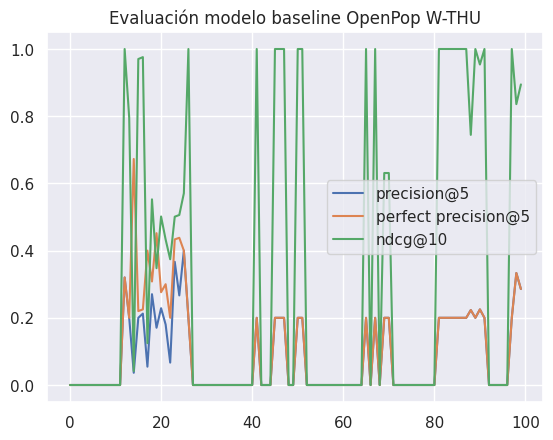

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.124405,0.468439,0.457242,0.500000,0.062202,0.468439,0.457242,0.500000,0.041468,0.468439,0.457242,0.500000,0.124405,0.062202,0.500000
std,0.136871,0.496049,0.486237,0.527046,0.068436,0.496049,0.486237,0.527046,0.045624,0.496049,0.486237,0.527046,0.136871,0.068436,0.527046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.100000,0.417984,0.388889,0.500000,0.050000,0.417984,0.388889,0.500000,0.033333,0.417984,0.388889,0.500000,0.100000,0.050000,0.500000
75%,0.218750,0.939038,0.917411,1.000000,0.109375,0.939038,0.917411,1.000000,0.072917,0.939038,0.917411,1.000000,0.218750,0.109375,1.000000
max,0.333333,1.000000,1.000000,1.000000,0.166667,1.000000,1.000000,1.000000,0.111111,1.000000,1.000000,1.000000,0.333333,0.166667,1.000000


,t,model,variable,value
0,2021-07-22 17:19:59,openpop,precision@5,0.0
1,2021-07-22 17:19:59,openpop,precision@5,0.0
2,2021-08-11 16:56:07,openpop,precision@5,0.0
3,2021-08-12 12:01:48,openpop,precision@5,0.0
4,2021-08-20 05:53:33,openpop,precision@5,0.0
...,...,...,...,...
395,2023-04-28 15:30:59,perfect,recall@5,0.0
396,2023-04-28 15:30:59,perfect,recall@5,0.0
397,2023-06-06 18:43:35,perfect,recall@5,1.0
398,2023-06-14 02:56:44,perfect,recall@5,1.0


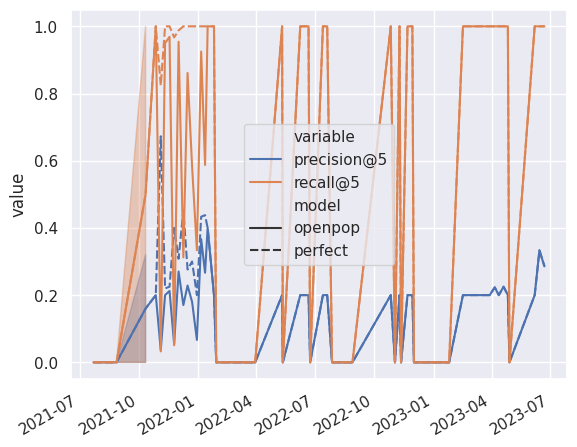

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2021-07-22 17:19:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2021-08-11 16:56:07,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2021-08-12 12:01:48,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
4,2021-08-20 05:53:33,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-04-28 15:30:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,perfect
96,2023-04-28 15:30:59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,perfect
97,2023-06-06 18:43:35,0.200000,1.0,1.0,1.0,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect
98,2023-06-14 02:56:44,0.333333,1.0,1.0,1.0,0.166667,1.0,1.0,1.0,0.111111,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

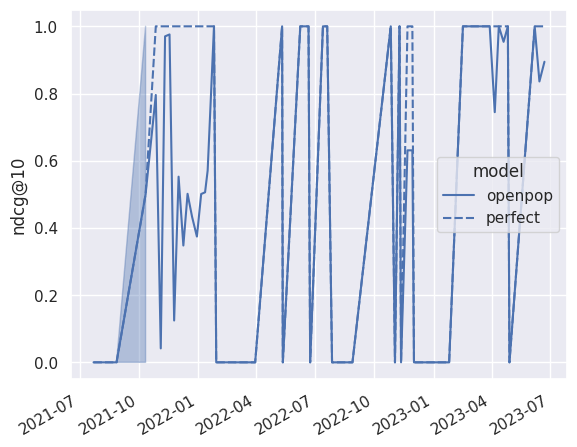

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.328358,1.0,0.993248,0.993248,0.168657,1.0,1.0,1.0,0.112438,1.0,1.0,1.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
9,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.101124,0.390000,0.387792,0.387792,0.052143,0.390000,0.389111,0.389111,0.035217,0.390000,0.389348,0.389348
std,0.142474,0.490207,0.487751,0.487751,0.077860,0.490207,0.489140,0.489140,0.053930,0.490207,0.489421,0.489421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
max,0.672727,1.000000,1.000000,1.000000,0.463636,1.000000,1.000000,1.000000,0.339394,1.000000,1.000000,1.000000


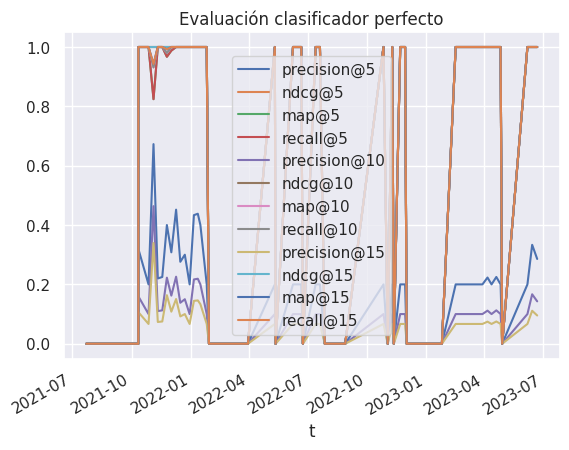

In [34]:
pmdf = pd.DataFrame(perfectmetrics).set_index('t')

pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 100 folds
From 2021-07-22 11:44:39 to 2023-07-01 00:51:20


,train,test,open,test users,test vpv,test vpp
count,100.000000,100.000000,100.000000,100.000000,40.000000,40.000000
mean,3051.690000,8.960000,6.790000,5.650000,0.832792,4.981242
std,1302.495885,22.768452,22.404588,13.375218,0.223280,5.664003
min,13.000000,0.000000,0.000000,0.000000,0.196078,0.298507
25%,3327.500000,0.000000,0.000000,0.000000,0.653721,1.000000
50%,3601.000000,0.000000,0.500000,0.000000,1.000000,3.000000
75%,3773.000000,3.250000,2.000000,3.250000,1.000000,6.000000
max,4069.000000,143.000000,144.000000,94.000000,1.000000,31.000000


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2021-07-29,13,0,1,0,NaN,NaN,NaT,NaT
1,2021-08-05,13,0,0,0,NaN,NaN,NaT,NaT
2,2021-08-12,65,0,3,0,NaN,NaN,NaT,NaT
3,2021-08-19,75,1,3,1,1.000000,1.0,2021-08-20 05:53:33,2021-08-20 05:53:33
4,2021-08-26,76,0,0,0,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...
95,2023-05-25,3983,0,0,0,NaN,NaN,NaT,NaT
96,2023-06-01,3983,0,0,0,NaN,NaN,NaT,NaT
97,2023-06-08,3987,37,2,32,0.864865,16.0,2023-06-08 00:53:59,2023-06-14 02:54:51
98,2023-06-15,4054,15,3,9,0.600000,3.0,2023-06-15 02:31:21,2023-06-21 22:09:04


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 38 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
24,2022-01-13,3293,46,6,21,0.456522,7.0,2022-01-14 15:58:10,2022-01-15 15:51:05,True,True
90,2023-04-20,3972,10,2,9,0.900000,4.5,2023-04-20 00:04:07,2023-04-26 04:50:33,True,True
91,2023-04-27,3982,1,2,1,1.000000,1.0,2023-04-28 15:30:59,2023-04-28 15:30:59,True,True


            train  test  i
t                         
2021-07-29     13     0  0
2021-08-05     13     0  1
2021-08-12     65     0  2
2021-08-19     75     1  3
2021-08-26     76     0  4
2021-09-02     77     0  5
2021-09-09     77     0  6
2021-09-16     77     0  7
2021-09-23     77     0  8
2021-09-30     77     0  9


Cannot show ipywidgets in text

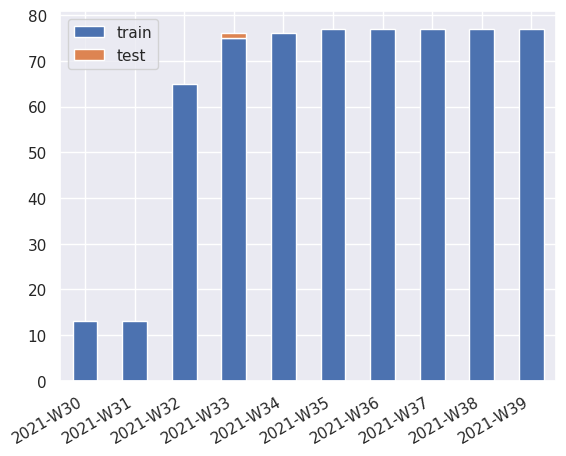

In [38]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

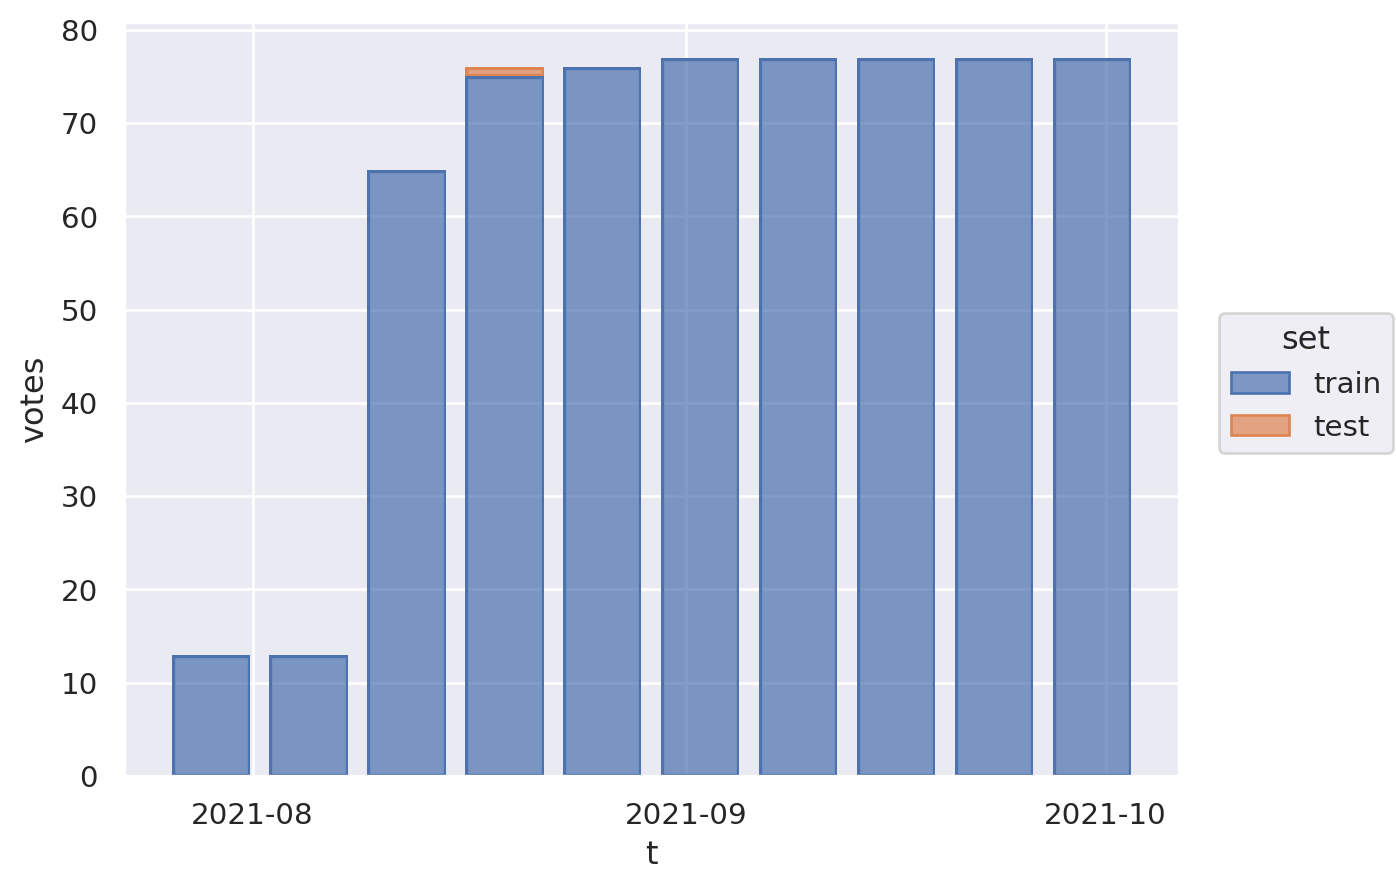

In [39]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())